# Using RNN variant LSTM to predict Forex Exchange Rate
The purpose of the project is to create and train a Recurrent Neural Network(RNN) to perform time series prediction on Forex exchange rates. The variant of RNNs to be used is the Long Short Term Memory(LSTM). This project adapts code from a Kaggle notebook that created a LSTM to predict IBM stock price highs. For reference, this notebook can be found at the link below:
https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers.legacy import SGD
import math
from sklearn.metrics import mean_squared_error
from pandas_datareader import data as web
import datetime

In [183]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Spot Exchange Rate')
    plt.plot(predicted, color='blue',label='Predicted Spot Exchange Rate')
    plt.title('USD-EUR Exchange Rate')
    plt.xlabel('Time')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Data Import
While the project being followed used an imported csv of IBM stock prices, this project will use webscraping to import the Forex spot exchange rate for USD to Euros

In [184]:
tickers = ['DEXUSEU']
data_source = 'fred'
start_date = '2020-01-01'
end_date = datetime.date.today()
df = web.DataReader(tickers, data_source,'2020-01-01', datetime.date.today())

## Data Exploration

In [185]:
df.head()

,DEXUSEU
DATE,
2020-01-01,NaN
2020-01-02,1.1166
2020-01-03,1.1173
2020-01-06,1.1187
2020-01-07,1.1138


Dataset contains 1060 which is not very large, more data may have to be added once Model Evaluation occurs

In [186]:
df.describe()

,DEXUSEU
count,1060.000000
mean,1.113045
std,0.061197
min,0.961600
25%,1.074300
50%,1.099050
75%,1.173325
max,1.229500


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1108 entries, 2020-01-01 to 2024-03-29
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXUSEU  1060 non-null   float64
dtypes: float64(1)
memory usage: 17.3 KB


There are only 48 null value to be removed in data cleaning.

In [188]:
total_rows = df.count()
print("Total Rows: ", total_rows)
rows_with_null = df.isnull().sum()
print("Rows with null: ", rows_with_null)

Total Rows:  DEXUSEU    1060
dtype: int64
Rows with null:  DEXUSEU    48
dtype: int64


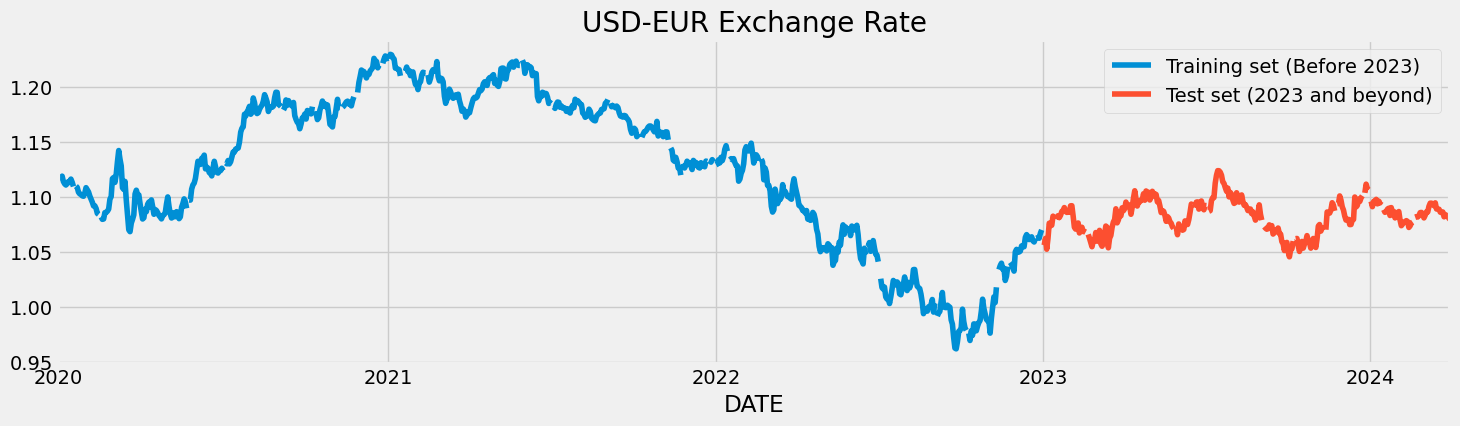

In [189]:
df["DEXUSEU"][:'2022'].plot(figsize=(16,4),legend=True)
df["DEXUSEU"]['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2023)','Test set (2023 and beyond)'])
plt.title('USD-EUR Exchange Rate')

plt.show()

## Data Preprocessing

Data cleaning is required here to remove null values

In [190]:
df = df.dropna()
df.isnull().sum()

DEXUSEU    0
dtype: int64

Now we split the training and test data. Test data will be any dates after 2023. Roughly a 70/30 split.<br>
Small modifications needed to suit switched dataset.

In [191]:
training_set = df[:'2022'].iloc[:,0:1].values
test_set = df['2023':].iloc[:,0:1].values

In [192]:
training_set.shape

(749, 1)

In [193]:
test_set.shape

(311, 1)

Next preprocessing step is to normalise the data.<br>
Small modification required to original notebook to get MinMaxScaler to work.

In [194]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

For training an LSTM we create sequences of time variant data using 60 previous times steps and their values. These sets of time periods are then used to train the model. In the code below we set the range to start at 60 for the first set of values obtained by i-60.

In [199]:
X_train = []
y_train = []
for i in range(60,749):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

First set of training data.

In [ ]:
X_train[0]

array([0.57857409, 0.58118701, 0.58641284, 0.56812243, 0.56028369,
       0.55617768, 0.56103024, 0.56812243, 0.56513624, 0.57633445,
       0.56550952, 0.55132512, 0.55244494, 0.54833893, 0.53191489,
       0.52631579, 0.52370287, 0.51959686, 0.51810377, 0.52855543,
       0.54721911, 0.53975364, 0.53266144, 0.51885032, 0.50877193,
       0.497947  , 0.48525569, 0.48562897, 0.4766704 , 0.45987309,
       0.45651362, 0.44755506, 0.43971631, 0.44083613, 0.462486  ,
       0.46323255, 0.46733856, 0.47443076, 0.50802538, 0.51698395,
       0.57782755, 0.58193356, 0.56513624, 0.59201194, 0.63568496,
       0.67338559, 0.64427025, 0.62112729, 0.54684584, 0.54124673,
       0.56849571, 0.50578574, 0.45427398, 0.40425532, 0.39790967,
       0.42702501, 0.43971631, 0.45502053, 0.52594252, 0.53863382])

Last set of training data.

In [ ]:
X_train[-1]

array([0.07204181, 0.13475177, 0.0933184 , 0.07092199, 0.06308324,
       0.05263158, 0.02836879, 0.06121687, 0.04591265, 0.08473311,
       0.08435984, 0.06121687, 0.07726764, 0.08921239, 0.09630459,
       0.12803285, 0.16871967, 0.13773796, 0.11870101, 0.1004106 ,
       0.09518477, 0.09667786, 0.05337813, 0.10414334, 0.14221725,
       0.17655842, 0.15714819, 0.20903322, 0.26913027, 0.28219485,
       0.29078014, 0.27062337, 0.27360956, 0.23217619, 0.24636058,
       0.27920866, 0.29339306, 0.28742068, 0.27622247, 0.26390444,
       0.32922732, 0.33781262, 0.32773423, 0.32885405, 0.33184024,
       0.3493841 , 0.34863755, 0.34677118, 0.37849944, 0.38783128,
       0.38148563, 0.37103397, 0.3762598 , 0.38036581, 0.36692796,
       0.36282195, 0.37513998, 0.38745801, 0.37551325, 0.39268384])

In [200]:
X_train.shape

(689, 60)

Reshaping to add a third dimension to fit the input layer and represent number of features at each time step.

In [201]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [202]:
X_train.shape

(689, 60, 1)

In [143]:
len(X_train)

689

## Model Creation

### Model 1

For the first model we will use the LSTM from the notebook to get an idea of its current performance on this task.<br>
Evaluating this model:<br>
1. Input Layer
- The input layer also serves as a processing layer
- This is a LSTM layer with 50 neurons (units) designed to process sequential data
- return_sequences is True which means this layer will output hidden states for each timestep which lower layers can access
2. Hidden Layers
- The model has four dropout layers to randomly drop data to prevent overfitting.
- The model has 3 further LSTM layers with 50 neurons with the last having return_sequence set to false by default
3. Output Layer
- The model has an output layer which will output a single continous value
4. Configuration
- The model uses the rmsprop optimiser
- The loss function is mean_squared_error as this is a Regression task


In [144]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
22/22 [==============================] - 7s 58ms/step - loss: 0.0648
Epoch 2/50
22/22 [==============================] - 1s 62ms/step - loss: 0.0264
Epoch 3/50
22/22 [==============================] - 1s 57ms/step - loss: 0.0196
Epoch 4/50
22/22 [==============================] - 1s 69ms/step - loss: 0.0191
Epoch 5/50
22/22 [==============================] - 1s 57ms/step - loss: 0.0178
Epoch 6/50
22/22 [==============================] - 1s 66ms/step - loss: 0.0154
Epoch 7/50
22/22 [==============================] - 1s 62ms/step - loss: 0.0179
Epoch 8/50
22/22 [==============================] - 1s 63ms/step - loss: 0.0143
Epoch 9/50
22/22 [==============================] - 2s 75ms/step - loss: 0.0128
Epoch 10/50
22/22 [==============================] - 1s 66ms/step - loss: 0.0117
Epoch 11/50
22/22 [==============================] - 2s 78ms/step - loss: 0.0130
Epoch 12/50
22/22 [==============================] - 2s 76ms/step - loss: 0.0117
Epoch 13/50
22/22 [==================

Model 1 architecture.

In [165]:
regressor.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_296 (LSTM)             (None, 60, 50)            10400     
                                                                 
 dropout_308 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_297 (LSTM)             (None, 60, 50)            20200     
                                                                 
 dropout_309 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_298 (LSTM)             (None, 60, 50)            20200     
                                                                 
 dropout_310 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_299 (LSTM)             (None, 50)              

Prepare a combined dataset for graphing

In [152]:
dataset_total = pd.concat((df["DEXUSEU"][:'2022'],df["DEXUSEU"]['2023':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
dataset_total

DATE
2020-01-02    1.1166
2020-01-03    1.1173
2020-01-06    1.1187
2020-01-07    1.1138
2020-01-08    1.1117
               ...  
2024-03-25    1.0837
2024-03-26    1.0829
2024-03-27    1.0821
2024-03-28    1.0801
2024-03-29    1.0791
Name: DEXUSEU, Length: 1060, dtype: float64

In [205]:
len(inputs)

371

In [206]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,371):
    X_test.append(inputs[i-60:i,0])


In [207]:
len(X_test)

311

In [156]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

10/10 [==============================] - 0s 25ms/step


#### Model 1 Evaluation

Model 1 performed very well with this task. We have a mean squared error of only 0.0096 which given our dataset is normalised between 0 and 1 is a good result. We can see that while the predicted values do not conform to small variations in the dataset, the line created does roughly follow the actual values quite well, especially when we consider the limited dataset used so far.

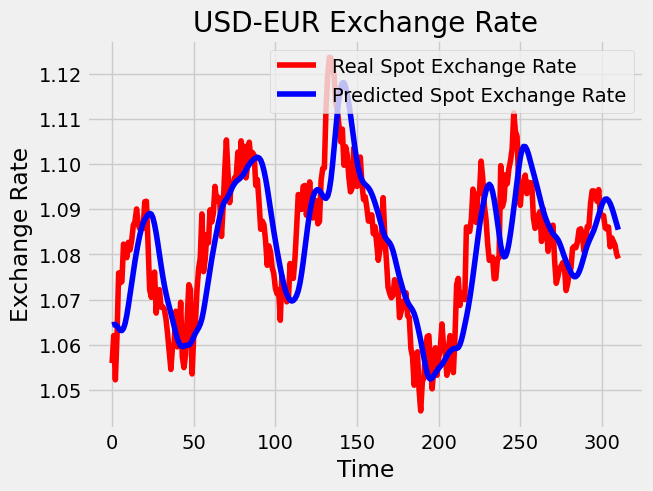

In [157]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [158]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 0.009617524894592283.


### Model 2
We saw that Model 1 was not conforming to small variations in the actual values so for Model 2, we add neurons and a fifth LSTM layer and reduce dropout to attempt to see if we can get a better fit.

In [218]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
22/22 [==============================] - 10s 97ms/step - loss: 0.0658
Epoch 2/50
22/22 [==============================] - 2s 95ms/step - loss: 0.0103
Epoch 3/50
22/22 [==============================] - 2s 91ms/step - loss: 0.0082
Epoch 4/50
22/22 [==============================] - 2s 93ms/step - loss: 0.0095
Epoch 5/50
22/22 [==============================] - 2s 96ms/step - loss: 0.0078
Epoch 6/50
22/22 [==============================] - 3s 114ms/step - loss: 0.0071
Epoch 7/50
22/22 [==============================] - 3s 114ms/step - loss: 0.0084
Epoch 8/50
22/22 [==============================] - 3s 116ms/step - loss: 0.0069
Epoch 9/50
22/22 [==============================] - 2s 113ms/step - loss: 0.0065
Epoch 10/50
22/22 [==============================] - 2s 113ms/step - loss: 0.0063
Epoch 11/50
22/22 [==============================] - 3s 119ms/step - loss: 0.0058
Epoch 12/50
22/22 [==============================] - 2s 112ms/step - loss: 0.0071
Epoch 13/50
22/22 [==========

#### Model 2 Evaluation

This Model performs almost identically to Model 1 with a MSE of .0093 meaning adding complexity  had no benefit in this case. This is probably because the dataset being used is small so there is not enough data for a more complex model to increase its performance.<br>
Another interesting observation is that the model predictions from both Model 1 and Model 2 seem to be offset from the true values. This may indicate that the model is learning to simply predict the previous value in the time series and is actually not learning the pattern at all. For the next attempt I will increase the dataset size and see if this improves this issue.

10/10 [==============================] - 3s 69ms/step


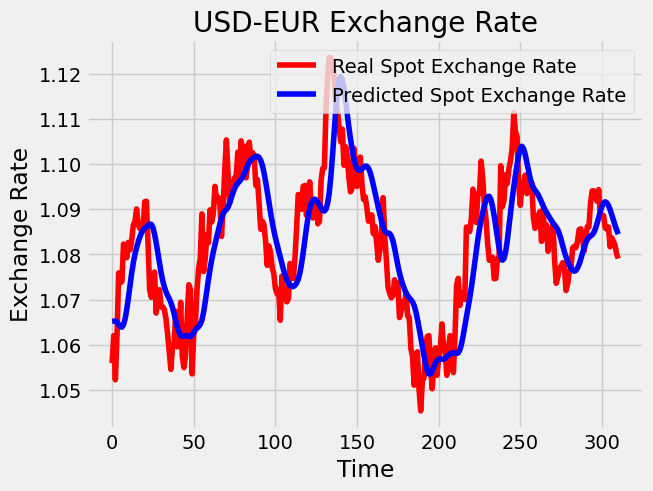

In [219]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
plot_predictions(test_set,predicted_stock_price)

In [220]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 0.00934351280850283.


### Model 3

Total Rows:  DEXUSEU    1558
dtype: int64
Rows with null:  DEXUSEU    72
dtype: int64


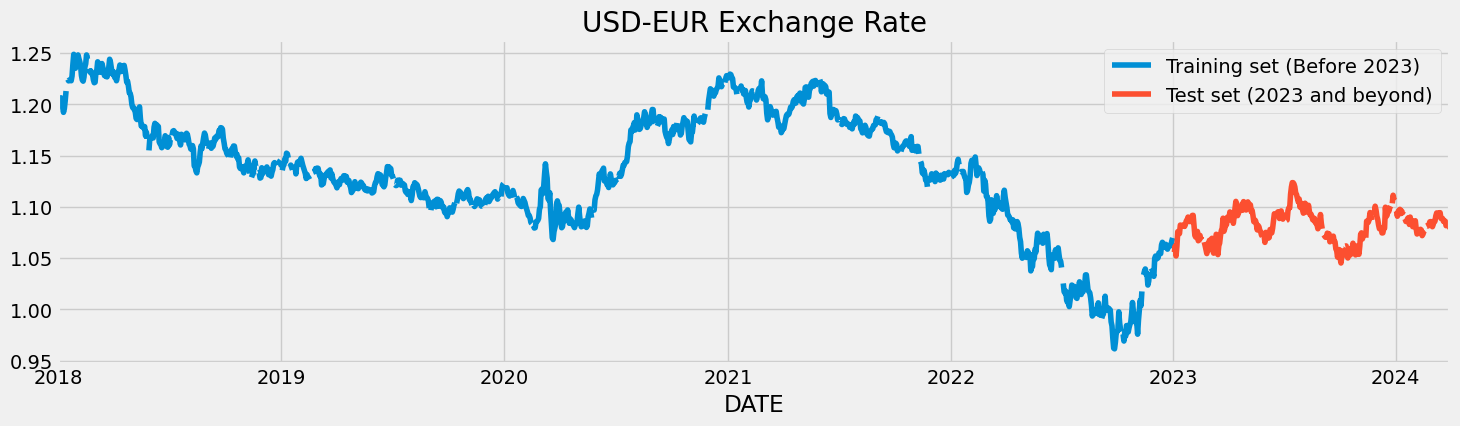

In [222]:
tickers = ['DEXUSEU']
end_date = datetime.date.today()
df_extended = web.DataReader(tickers, 'fred','2018-01-01', datetime.date.today())
total_rows = df_extended.count()
print("Total Rows: ", total_rows)
rows_with_null = df_extended.isnull().sum()
print("Rows with null: ", rows_with_null)
# We have chosen 'High' attribute for prices. Let's see what it looks like
df_extended["DEXUSEU"][:'2022'].plot(figsize=(16,4),legend=True)
df_extended["DEXUSEU"]['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2023)','Test set (2023 and beyond)'])
plt.title('USD-EUR Exchange Rate')

plt.show()

Create new training and test data

In [223]:
df_extended = df_extended.dropna()
df_extended.isnull().sum()
training_set_e = df_extended[:'2022'].iloc[:,0:1].values
test_set_e = df_extended['2023':].iloc[:,0:1].values
sc = MinMaxScaler()
training_set_scaled_e = sc.fit_transform(training_set_e)
X_train_e = []
y_train_e = []
for i in range(60,749):
    X_train_e.append(training_set_scaled_e[i-60:i,0])
    y_train_e.append(training_set_scaled_e[i,0])
X_train_e, y_train_e = np.array(X_train_e), np.array(y_train_e)
X_train_e = np.reshape(X_train_e, (X_train_e.shape[0],X_train_e.shape[1],1))

In [224]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_e.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train_e,y_train_e,epochs=50,batch_size=32)

Epoch 1/50
22/22 [==============================] - 18s 249ms/step - loss: 0.0665
Epoch 2/50
22/22 [==============================] - 5s 240ms/step - loss: 0.0106
Epoch 3/50
22/22 [==============================] - 6s 258ms/step - loss: 0.0075
Epoch 4/50
22/22 [==============================] - 6s 275ms/step - loss: 0.0061
Epoch 5/50
22/22 [==============================] - 5s 237ms/step - loss: 0.0053
Epoch 6/50
22/22 [==============================] - 5s 202ms/step - loss: 0.0056
Epoch 7/50
22/22 [==============================] - 5s 244ms/step - loss: 0.0057
Epoch 8/50
22/22 [==============================] - 5s 249ms/step - loss: 0.0058
Epoch 9/50
22/22 [==============================] - 6s 255ms/step - loss: 0.0054
Epoch 10/50
22/22 [==============================] - 5s 218ms/step - loss: 0.0044
Epoch 11/50
22/22 [==============================] - 6s 261ms/step - loss: 0.0052
Epoch 12/50
22/22 [==============================] - 6s 252ms/step - loss: 0.0044
Epoch 13/50
22/22 [=====

In [225]:
dataset_total_e = pd.concat((df_extended["DEXUSEU"][:'2022'],df_extended["DEXUSEU"]['2023':]),axis=0)
inputs_e = dataset_total_e[len(dataset_total_e)-len(test_set_e) - 60:].values
inputs_e = inputs_e.reshape(-1,1)
inputs_e  = sc.transform(inputs_e)
dataset_total_e

DATE
2018-01-02    1.2050
2018-01-03    1.2030
2018-01-04    1.2064
2018-01-05    1.2039
2018-01-08    1.1973
               ...  
2024-03-25    1.0837
2024-03-26    1.0829
2024-03-27    1.0821
2024-03-28    1.0801
2024-03-29    1.0791
Name: DEXUSEU, Length: 1558, dtype: float64

In [226]:
len(inputs_e)

371

In [227]:
X_test_e = []
for i in range(60,371):
    X_test_e.append(inputs_e[i-60:i,0])


#### Model 3 Evaluation
No improvement given more data which is not really surprising as it seems clear now that the model is learning to simply predict the previous value as once again the prediction is just the real spot prices shifted forward. The next steps I will try is to add more indicators from which the model can learn as predicting a Forex price in a vacuum is probably impossible given that its pattern is controlled by external factors more than having a particular pattern a model can learn.

10/10 [==============================] - 3s 78ms/step


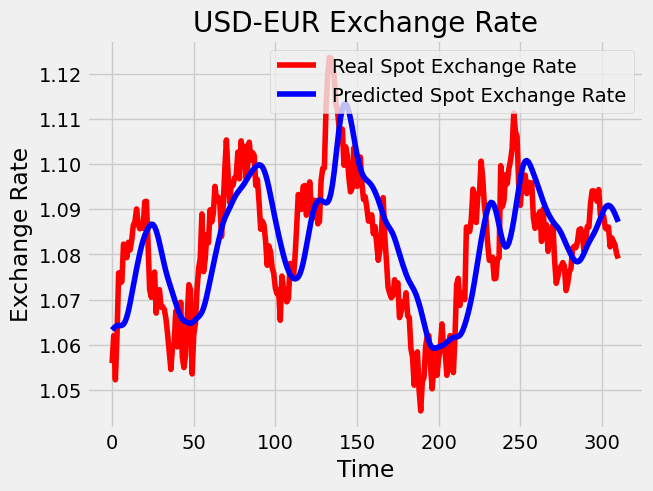

In [228]:
X_test_e = np.array(X_test_e)
X_test_e = np.reshape(X_test_e, (X_test_e.shape[0],X_test_e.shape[1],1))
predicted_stock_price = regressor.predict(X_test_e)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
plot_predictions(test_set_e,predicted_stock_price)

In [229]:
return_rmse(test_set_e,predicted_stock_price)

The root mean squared error is 0.010632440601416345.


### Model 4

#### Additional Features
For the next model, we will attempt to include some external indicators that could indicate market sentiment and thus give the model more data on how the exchange rate may change. Credit to Paul Bacher's guide found here for these indicators: https://www.kaggle.com/code/paulbacher/forex-trend-predictions-classic-ml-approach

In [248]:
import pandas_ta as ta
import yfinance as yf

dfn = yf.download(tickers='USDEUR=X',
                 period='2000d',
                 interval='1d')
dfn= dfn.drop(['Volume', 'Adj Close'], axis=1)
dfn.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2016-08-08,0.90190,0.903040,0.900414,0.90175
2016-08-09,0.90197,0.903179,0.899119,0.90223
2016-08-10,0.89943,0.899430,0.892857,0.89962
2016-08-11,0.89397,0.897827,0.893580,0.89394
2016-08-12,0.89775,0.898260,0.891266,0.89774


In [240]:
dfn.tail()

,Open,High,Low,Close
Date,,,,
2024-04-01,0.92655,0.93183,0.92580,0.92655
2024-04-02,0.93134,0.93237,0.92775,0.93134
2024-04-03,0.92863,0.92896,0.92320,0.92863
2024-04-04,0.92265,0.92293,0.91947,0.92265
2024-04-05,0.92230,0.92630,0.92170,0.92260


In [232]:
dfn.describe()

,Open,High,Low,Close
count,2995.000000,2995.000000,2995.000000,2995.000000
mean,0.866414,0.869226,0.863664,0.866400
std,0.067305,0.067854,0.066736,0.067304
min,0.717880,0.718773,0.714740,0.717830
25%,0.828270,0.830665,0.826550,0.828100
50%,0.883170,0.885870,0.880300,0.883160
75%,0.913930,0.917085,0.911074,0.913895
max,1.042080,1.048200,1.034120,1.042080


Get more indicators

In [249]:
dfn.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

1. ATR (Average True Range): Measures market volatility by calculating the average range between the high and low prices over a specified period (in this case, 20 days).
2. RSI (Relative Strength Index): Indicates the magnitude of recent price changes to evaluate whether a stock is overbought or oversold, typically over a 14-day period by default.
3. Average: Calculates the average price between the high and low prices for each day, providing a reference point for market activity over a one-day period.
4. MA40 (40-day Moving Average): Smooths out price data by calculating the average closing price over the past 40 days, providing insight into the overall trend direction.
5. MA80 (80-day Moving Average): Similar to MA40 but calculates the average closing price over the past 80 days, offering a longer-term perspective on the trend direction.
6. MA160 (160-day Moving Average): Computes the average closing price over the past 160 days, providing an even longer-term view of the trend direction and smoothing out short-term fluctuations.

In [250]:
dfn['ATR'] = dfn.ta.atr(length=20)
dfn['RSI'] = dfn.ta.rsi()
dfn['Average'] = dfn.ta.midprice(length=1)
dfn['MA40'] = dfn.ta.sma(length=40)
dfn['MA80'] = dfn.ta.sma(length=80)
dfn['MA160'] = dfn.ta.sma(length=160)

Drop any rows with Nan values

In [256]:
dfn = dfn.dropna()
dfn.isnull().sum()

Open       0
High       0
Low        0
Close      0
ATR        0
RSI        0
Average    0
MA40       0
MA80       0
MA160      0
dtype: int64

Now we prepare the new extended dataset for Model Training

In [257]:
dfn.head()

,Open,High,Low,Close,ATR,RSI,Average,MA40,MA80,MA160
Date,,,,,,,,,,
2017-03-17,0.92846,0.93198,0.927386,0.92810,0.007521,38.137056,0.929683,0.938900,0.942946,0.922994
2017-03-20,0.93090,0.93090,0.927902,0.93084,0.007295,41.138971,0.929401,0.938837,0.942803,0.923176
2017-03-21,0.93138,0.93138,0.924300,0.93130,0.007284,41.650843,0.927840,0.938887,0.942676,0.923358
2017-03-22,0.92496,0.92794,0.924150,0.92486,0.007277,36.822606,0.926045,0.938706,0.942498,0.923515
2017-03-23,0.92681,0.92846,0.925500,0.92677,0.007093,39.078216,0.926980,0.938624,0.942281,0.923720


Move close to end of dataset

In [279]:
close_column = dfn.pop('Close')
dfn['Close'] = close_column

In [280]:
dfn.head()

,Open,High,Low,ATR,RSI,Average,MA40,MA80,MA160,Close
Date,,,,,,,,,,
2017-03-17,0.92846,0.93198,0.927386,0.007521,38.137056,0.929683,0.938900,0.942946,0.922994,0.92810
2017-03-20,0.93090,0.93090,0.927902,0.007295,41.138971,0.929401,0.938837,0.942803,0.923176,0.93084
2017-03-21,0.93138,0.93138,0.924300,0.007284,41.650843,0.927840,0.938887,0.942676,0.923358,0.93130
2017-03-22,0.92496,0.92794,0.924150,0.007277,36.822606,0.926045,0.938706,0.942498,0.923515,0.92486
2017-03-23,0.92681,0.92846,0.925500,0.007093,39.078216,0.926980,0.938624,0.942281,0.923720,0.92677


In [298]:
dfn['2023':].iloc[:,0:9]

,Open,High,Low,ATR,RSI,Average,MA40,MA80,MA160
Date,,,,,,,,,
2023-01-02,0.93373,0.93868,0.93350,0.008717,32.925536,0.936090,0.956417,0.985754,0.978679
2023-01-03,0.93653,0.95043,0.93610,0.009116,36.790537,0.943265,0.954877,0.985120,0.978682
2023-01-04,0.94815,0.94823,0.94060,0.009245,49.735193,0.944415,0.953781,0.984449,0.978786
2023-01-05,0.94283,0.95097,0.94050,0.009306,45.173948,0.945735,0.952401,0.983715,0.978831
2023-01-06,0.95037,0.95372,0.94142,0.009456,51.906143,0.947570,0.951631,0.983080,0.978947
...,...,...,...,...,...,...,...,...,...
2024-04-01,0.92655,0.93183,0.92580,0.005074,58.674961,0.928815,0.923052,0.919183,0.926347
2024-04-02,0.93134,0.93237,0.92775,0.005111,64.627505,0.930060,0.923062,0.919215,0.926433
2024-04-03,0.92863,0.92896,0.92320,0.005263,59.413298,0.926080,0.923037,0.919247,0.926475


In [316]:
dfn['2023':].iloc[:,0:10]

,Open,High,Low,ATR,RSI,Average,MA40,MA80,MA160,Close
Date,,,,,,,,,,
2023-01-02,0.93373,0.93868,0.93350,0.008717,32.925536,0.936090,0.956417,0.985754,0.978679,0.93373
2023-01-03,0.93653,0.95043,0.93610,0.009116,36.790537,0.943265,0.954877,0.985120,0.978682,0.93653
2023-01-04,0.94815,0.94823,0.94060,0.009245,49.735193,0.944415,0.953781,0.984449,0.978786,0.94815
2023-01-05,0.94283,0.95097,0.94050,0.009306,45.173948,0.945735,0.952401,0.983715,0.978831,0.94283
2023-01-06,0.95037,0.95372,0.94142,0.009456,51.906143,0.947570,0.951631,0.983080,0.978947,0.95037
...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0.92655,0.93183,0.92580,0.005074,58.674961,0.928815,0.923052,0.919183,0.926347,0.92655
2024-04-02,0.93134,0.93237,0.92775,0.005111,64.627505,0.930060,0.923062,0.919215,0.926433,0.93134
2024-04-03,0.92863,0.92896,0.92320,0.005263,59.413298,0.926080,0.923037,0.919247,0.926475,0.92863


In [403]:
training_set_n = dfn[:'2022'].iloc[:,0:10].values
test_set_en= dfn['2023':].iloc[:,0:10].values
sc = MinMaxScaler()
training_set_scaled_n = sc.fit_transform(training_set_n)

In [325]:
test_set_en[0,9]

0.9337300062179565

In [307]:
len(training_set_scaled_n)

1508

In [319]:
X_train_n = []
y_train_n = []
for i in range(60,1508):
    X_train_n.append(training_set_scaled_n[i-60:i,0:8])
    y_train_n.append(training_set_scaled_n[i,9])
X_train_n, y_train_n = np.array(X_train_n), np.array(y_train_n)
X_train_n = np.reshape(X_train_n, (X_train_n.shape[0],X_train_n.shape[1],8))

#### Model Creation

In [326]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_n.shape[1],8)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train_n,y_train_n,epochs=50,batch_size=32)

Epoch 1/50
46/46 [==============================] - 27s 280ms/step - loss: 0.0131
Epoch 2/50
46/46 [==============================] - 12s 270ms/step - loss: 0.0041
Epoch 3/50
46/46 [==============================] - 12s 265ms/step - loss: 0.0033
Epoch 4/50
46/46 [==============================] - 13s 285ms/step - loss: 0.0034
Epoch 5/50
46/46 [==============================] - 13s 272ms/step - loss: 0.0031
Epoch 6/50
46/46 [==============================] - 12s 266ms/step - loss: 0.0026
Epoch 7/50
46/46 [==============================] - 12s 257ms/step - loss: 0.0025
Epoch 8/50
46/46 [==============================] - 12s 265ms/step - loss: 0.0024
Epoch 9/50
46/46 [==============================] - 13s 283ms/step - loss: 0.0030
Epoch 10/50
46/46 [==============================] - 12s 260ms/step - loss: 0.0024
Epoch 11/50
46/46 [==============================] - 13s 273ms/step - loss: 0.0022
Epoch 12/50
46/46 [==============================] - 11s 238ms/step - loss: 0.0021
Epoch 13/50
4

In [396]:
dataset_total_n = pd.concat((dfn[:'2022'],dfn['2023':]),axis=0)
inputs_n = dataset_total_n[len(dataset_total_n)-len(test_set_en) - 60:].values
inputs_n = inputs_n.reshape(-1,10)
inputs_n  = sc.transform(inputs_n)
inputs_features_n = inputs_n[:, :9]
inputs_target_n = inputs_n[:, 9:]
# Scale the features and target separately
inputs_features_n = sc.fit_transform(inputs_features_n)
inputs_target_n = sc.fit_transform(inputs_target_n.reshape(-1, 1))

# Combine the scaled features and target
inputs_n = np.concatenate((inputs_features_n, inputs_target_n), axis=1)

In [397]:
len(inputs_n)

390

In [398]:
# Prepare the test data
X_test_n = []
for i in range(60, 390):
    X_test_n.append(inputs_n[i-60:i, 0:8])

X_test_n = np.array(X_test_n)
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], X_test_n.shape[1], 8))

# Get the normalized predictions
predicted_stock_price = regressor.predict(X_test_n)

# Inverse transform the predictions to get the unnormalized values
predicted_stock_price_unscaled = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))
plot_predictions(test_set_en[:,9],predicted_stock_price_unscaled)

11/11 [==============================] - 0s 43ms/step


11/11 [==============================] - 0s 35ms/step


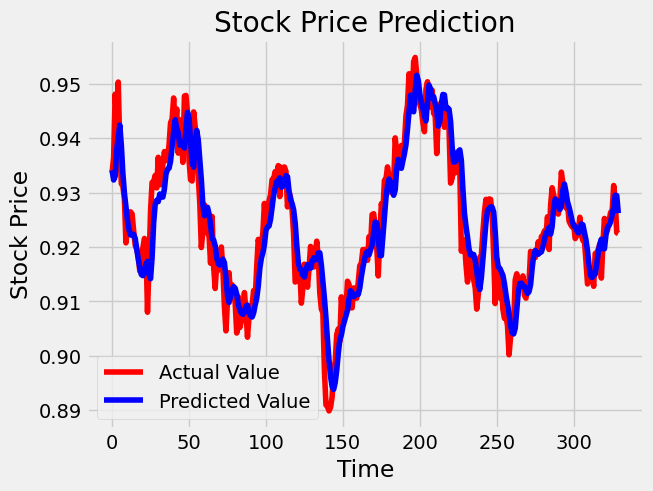

In [406]:
# Prepare test data
dataset_total_n = pd.concat((dfn[:'2022'], dfn['2023':]), axis=0)
inputs_n = dataset_total_n[len(dataset_total_n)-len(test_set_en) - 60:].values
inputs_n = inputs_n.reshape(-1, 10)
inputs_features_n = inputs_n[:, :9]
inputs_target_n = inputs_n[:, 9:]
inputs_features_n = sc.fit_transform(inputs_features_n)
inputs_target_n = sc.fit_transform(inputs_target_n.reshape(-1, 1))
inputs_n = np.concatenate((inputs_features_n, inputs_target_n), axis=1)

# Prepare the test data
X_test_n = []
for i in range(60, 390):
    X_test_n.append(inputs_n[i-60:i, 0:8])
X_test_n = np.array(X_test_n)
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], X_test_n.shape[1], 8))

# Get the normalized predictions
predicted_stock_price = regressor.predict(X_test_n)

# Inverse transform the predictions to get the unnormalized values
predicted_stock_price_unscaled = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

# Plot predictions
plt.plot(test_set_en[:, 9], color='red', label='Actual Value')
plt.plot(predicted_stock_price_unscaled, color='blue', label='Predicted Value')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [407]:
return_rmse(test_set_en[:, 9],predicted_stock_price_unscaled)

The root mean squared error is 0.004757133174256829.


In [408]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_n.shape[1],8), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_n.shape[1],8), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_n.shape[1],8), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train_n,y_train_n,epochs=50,batch_size=150)

Epoch 1/50


C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 10s 112ms/step - loss: 0.0404
Epoch 2/50
10/10 [==============================] - 1s 100ms/step - loss: 0.0147
Epoch 3/50
10/10 [==============================] - 1s 108ms/step - loss: 0.0074
Epoch 4/50
10/10 [==============================] - 1s 100ms/step - loss: 0.0062
Epoch 5/50
10/10 [==============================] - 1s 101ms/step - loss: 0.0049
Epoch 6/50
10/10 [==============================] - 1s 104ms/step - loss: 0.0051
Epoch 7/50
10/10 [==============================] - 1s 99ms/step - loss: 0.0039
Epoch 8/50
10/10 [==============================] - 1s 139ms/step - loss: 0.0045
Epoch 9/50
10/10 [==============================] - 1s 119ms/step - loss: 0.0041
Epoch 10/50
10/10 [==============================] - 1s 133ms/step - loss: 0.0040
Epoch 11/50
10/10 [==============================] - 1s 127ms/step - loss: 0.0038
Epoch 12/50
10/10 [==============================] - 1s 136ms/step - loss: 0.0035
Epoch 13/50
10/10 [=================

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [171]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,371):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

10/10 [==============================] - 2s 21ms/step


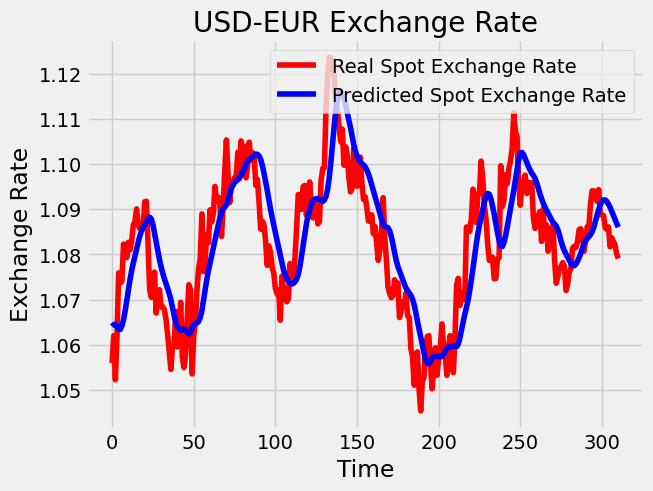

In [172]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

11/11 [==============================] - 2s 24ms/step


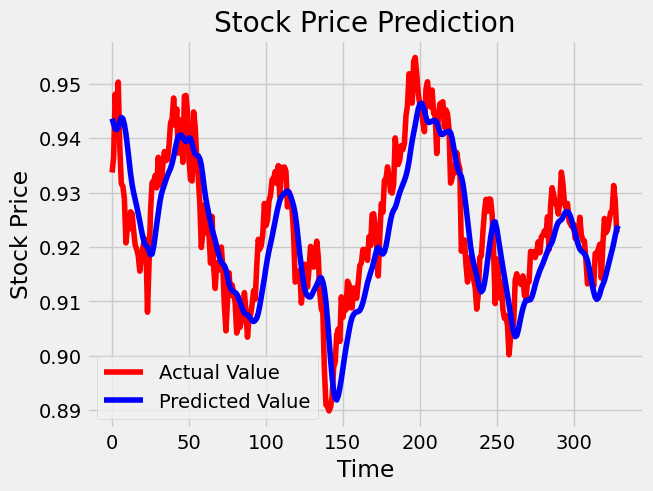

In [409]:
# Prepare test data
dataset_total_n = pd.concat((dfn[:'2022'], dfn['2023':]), axis=0)
inputs_n = dataset_total_n[len(dataset_total_n)-len(test_set_en) - 60:].values
inputs_n = inputs_n.reshape(-1, 10)
inputs_features_n = inputs_n[:, :9]
inputs_target_n = inputs_n[:, 9:]
inputs_features_n = sc.fit_transform(inputs_features_n)
inputs_target_n = sc.fit_transform(inputs_target_n.reshape(-1, 1))
inputs_n = np.concatenate((inputs_features_n, inputs_target_n), axis=1)

# Prepare the test data
X_test_n = []
for i in range(60, 390):
    X_test_n.append(inputs_n[i-60:i, 0:8])
X_test_n = np.array(X_test_n)
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], X_test_n.shape[1], 8))

# Get the normalized predictions
predicted_stock_price = regressorGRU.predict(X_test_n)

# Inverse transform the predictions to get the unnormalized values
predicted_stock_price_unscaled = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

# Plot predictions
plt.plot(test_set_en[:, 9], color='red', label='Actual Value')
plt.plot(predicted_stock_price_unscaled, color='blue', label='Predicted Value')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [410]:
# Evaluating GRU
return_rmse(test_set_en[:, 9],predicted_stock_price_unscaled)

The root mean squared error is 0.007224624217096502.


## Sequence Generation
Here, I will generate a sequence using just initial 60 values instead of using last 60 values for every new prediction. **Due to doubts in various comments about predictions making use of test set values, I have decided to include sequence generation.** The above models make use of test set so it is using last 60 true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

I will use GRU model for predictions. You can try this using LSTMs also. I have modified GRU model above to get the best sequence possible. I have run the model four times and two times I got error of around 8 to 9. The worst case had an error of around 11. Let's see what this iterations.

The GRU model in the previous versions is fine too. Just a little tweaking was required to get good sequences. **The main goal of this kernel is to show how to build RNN models. How you predict data and what kind of data you predict is up to you. I can't give you some 100 lines of code where you put the destination of training and test set and get world-class results. That's something you have to do yourself.**

In [176]:
# Preparing sequence data
initial_sequence = X_train[688,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

1/1 [==============================] - 0s 30ms/step


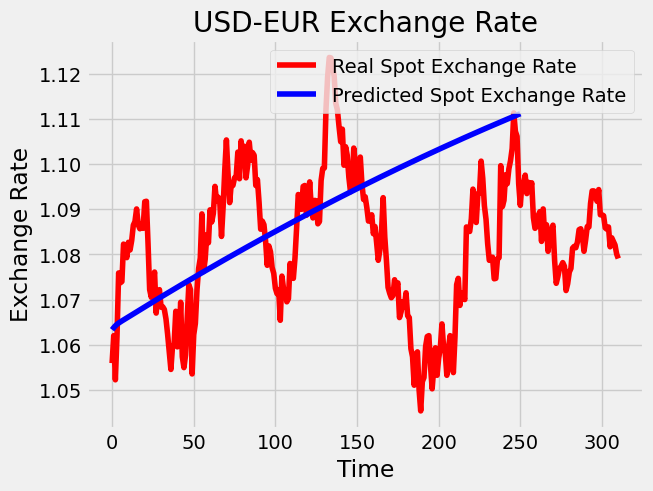

In [177]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [178]:
# Evaluating the sequence
return_rmse(test_set,sequence)

ValueError: Found input variables with inconsistent numbers of samples: [311, 251]

So, GRU works better than LSTM in this case. Bidirectional LSTM is also a good way so make the model stronger. But this may vary for different data sets. **Applying both LSTM and GRU together gave even better results.** 

#### I was going to cover text generation using LSTM but already an excellent kernel by [Shivam Bansal](https://www.kaggle.com/shivamb) on the mentioned topic exists. Link for that kernel here: https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms

#### This is certainly not the end. Stay tuned for more stuff!